
# **OpenCV Día 1 — La cámara como matriz**
**Objetivo del día:** Comprender la naturaleza matricial de las imágenes, los espacios de color más usados (BGR/RGB/HSV/LAB/YCrCb) y dominar las operaciones básicas de carga, visualización, guardado y conversión de color en OpenCV.

**Requisitos:** Python ≥ 3.9, `opencv-python`, `numpy`, `matplotlib`.

**Entregables:** 
- Scripts/notebook con ejemplos de carga y conversión de color.
- Ejercicios resueltos con validaciones visuales y numéricas.



## 1. Fundamentos teóricos y matemáticos

### 1.1 Imagen como función/matriz
Una imagen digital puede modelarse como una función **muestrada y cuantizada**:
$$
I:\Omega \subset \mathbb{Z}^2 \to \mathbb{R}^C,\quad I(x,y) = \big(I_1(x,y),\dots,I_C(x,y)\big)
$$
donde:
- $$(x,y)$ son coordenadas de píxel en una retícula regular,
- $C$ es el número de canales (1 en escala de grises, 3 en color),
- la intensidad suele estar cuantizada en 8 bits $(0$–$255)$ o en punto flotante normalizado $[0,1]$.

**Tensor de imagen:** En memoria práctica, una imagen color se representa como un tensor $H \times W \times C$, con **H** (alto), **W** (ancho) y **C** (canales). En OpenCV (Python), el orden por defecto es **BGR** para imágenes de 3 canales tipo `uint8`.



### 1.2 Muestreo y cuantización
- **Muestreo:** discretización espacial; la resolución $H\times W$ fija la frecuencia de muestreo.
- **Cuantización:** discretización en intensidad; típico: 8 bits $\Rightarrow$ 256 niveles por canal.
- **Tipos de datos (dtype):** `uint8` (0–255), `uint16` (0–65535), `float32` (0–1 o rangos arbitrarios).

**Nota crítica:** Muchas funciones de OpenCV esperan rangos diferentes según el `dtype`. Por ejemplo, para `float32` normalizado, asegúrate de escalar correctamente antes/después de convertir color.



### 1.3 Orden de canales y disposición en memoria
- **Orden de canales:** OpenCV usa **BGR**, mientras que bibliotecas como `matplotlib` y PIL usan **RGB**.
- **Strides:** el tensor de imagen tiene un **stride** (salto) por dimensión que determina el desplazamiento en memoria entre elementos adyacentes. Esto afecta el rendimiento y algunas vistas con slicing.
- **Implicación práctica:** cuidado al mostrar con `matplotlib.imshow` (espera RGB). Convertir BGR→RGB para visualizar colores reales.



### 1.4 Espacios de color fundamentales
1. **RGB/BGR**: espacio aditivo ligado al dispositivo. No es perceptualmente uniforme.
2. **HSV** (Hue-Saturation-Value): separación de **tono** (ángulo en \([0,360)\)), **saturación** y **valor** (brillo). Útil para segmentación por color bajo variación de iluminación.
3. **LAB** (CIELAB): diseñado para aproximar la percepción humana; casi uniforme perceptualmente. `L*` (luminosidad), `a*` (verde↔rojo), `b*` (azul↔amarillo). Requiere referencia de blanco (D65 por defecto en OpenCV al convertir desde sRGB).
4. **YCrCb**: separación de luminancia (Y) y crominancia (Cr, Cb); útil en compresión y segmentación basada en luminancia.

**Modelos matemáticos simplificados:**  
- **HSV (normalizado):**
  Sea \((R,G,B)\in[0,1]^3\), \(M=\max(R,G,B)\), \(m=\min(R,G,B)\), \(\Delta=M-m\).
  \[
  V=M,\quad S=\begin{cases}
  0 & \text{si } M=0,\\
  \Delta/M & \text{en otro caso}
  \end{cases}
  \]
  El **tono** \(H\) (en grados) es:
  \[
  H = \begin{cases}
  0 & \Delta=0,\\
  60^\circ \cdot \big((G-B)/\Delta \bmod 6\big) & M=R,\\
  60^\circ \cdot \big((B-R)/\Delta + 2\big) & M=G,\\
  60^\circ \cdot \big((R-G)/\Delta + 4\big) & M=B.
  \end{cases}
  \]
- **YCrCb (BT.601 aprox., 8 bits):**
  \[
  Y  = 0.299R + 0.587G + 0.114B,\quad
  Cb = \frac{B - Y}{1.772},\quad
  Cr = \frac{R - Y}{1.402}.
  \]
- **LAB** se define vía un paso intermedio RGB→XYZ (lineal) y XYZ→LAB (no lineal); 
  \(\mathrm{LAB}\) es más adecuado para distancias perceptuales (\(\Delta E\)).



### 1.5 Advertencias prácticas
- **Gamma/sRGB:** RGB habitual es **no lineal** (curva sRGB). Convertir a LAB/HSV en OpenCV asume sRGB estándar. Si trabajas con datos lineales, documenta y conserva esa linealidad.
- **Rangos:** `cv2.cvtColor` ajusta rangos según `dtype`. Para `uint8`, HSV usa \(H\in[0,179], S\in[0,255], V\in[0,255]\) por eficiencia interna.
- **Copias vs vistas:** Operaciones como `img[:,:,::-1]` crean vistas/c copias; medir con `np.shares_memory` si te importa el rendimiento/memoria.


In [1]:

# === Configuración inicial ===
import sys, cv2, numpy as np, matplotlib.pyplot as plt

print("Python:", sys.version.split()[0])
print("OpenCV:", cv2.__version__)
print("NumPy:", np.__version__)


Python: 3.12.0
OpenCV: 4.12.0
NumPy: 2.1.3


In [2]:

# Utilidad para mostrar imágenes (maneja BGR/RGB automáticamente)
def imshow(title, img, bgr=True):
    plt.figure()
    if img.ndim == 2:
        plt.imshow(img, cmap='gray')
    else:
        if bgr:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    plt.title(title)
    plt.axis('off')



## 2. Ejemplos prácticos guiados
Para evitar dependencias de red, generaremos imágenes sintéticas y también podrás cargar tus propias imágenes si lo deseas.


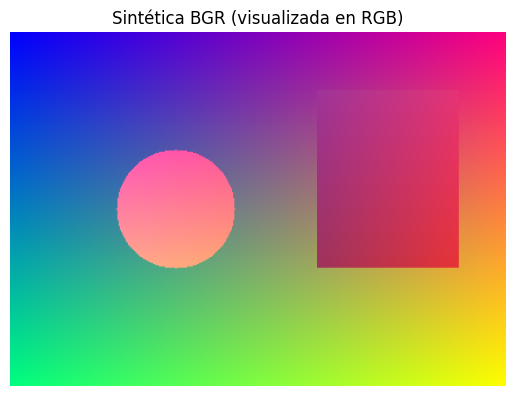

In [3]:

# Generar una imagen sintética: gradiente + formas geométricas
H, W = 300, 420
x = np.linspace(0, 1, W, dtype=np.float32)
y = np.linspace(0, 1, H, dtype=np.float32)
X, Y = np.meshgrid(x, y)

# Canales base en float [0,1]
R = np.clip(X, 0, 1)
G = np.clip(Y, 0, 1)
B = np.clip(1 - 0.5*X - 0.5*Y, 0, 1)

rgb = np.dstack([R, G, B]).copy()

# Dibujar un círculo y un rectángulo en el canal R y G
center = (W//3, H//2)
radius = min(H, W)//6
mask_circle = (np.square(np.arange(W) - center[0])[None,:] + np.square(np.arange(H) - center[1])[:,None]) <= radius**2
rgb[...,0][mask_circle] = 1.0  # R más intenso en el círculo
rgb[...,1][50:200, 260:380] = 0.2  # rectángulo con menos G

# Convertimos a uint8 BGR para OpenCV
bgr = (rgb[..., ::-1] * 255.0).astype(np.uint8)  # RGB->BGR
imshow("Sintética BGR (visualizada en RGB)", bgr, bgr=True)


In [ ]:

# (Opcional) Cargar tu propia imagen: coloca 'mi_imagen.jpg' junto a este notebook
# Descomenta para probar con tu imagen real
# bgr = cv2.imread('mi_imagen.jpg')
# if bgr is None:
#     raise FileNotFoundError("No se encontró 'mi_imagen.jpg'.")
# imshow("Mi imagen (BGR)", bgr)



### 2.1 Operaciones con canales y tipos
- Separar y unir canales.
- Inspeccionar `dtype`, forma, y rangos.


In [ ]:

print("Forma:", bgr.shape, "dtype:", bgr.dtype)
b, g, r = cv2.split(bgr)
print("Rango B:", (b.min(), b.max()), "Rango G:", (g.min(), g.max()), "Rango R:", (r.min(), r.max()))

# Reconstruir y verificar
bgr_recon = cv2.merge([b, g, r])
print("Reconstrucción idéntica:", np.array_equal(bgr, bgr_recon))

# Mostrar cada canal
imshow("Canal R", r, bgr=False)  # monocromo
imshow("Canal G", g, bgr=False)
imshow("Canal B", b, bgr=False)



### 2.2 Conversiones de color con `cv2.cvtColor`
- **BGR↔RGB**
- **BGR↔HSV**
- **BGR↔LAB**
- **BGR↔YCrCb**


In [ ]:

rgb_cv = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
ycrcb = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)

# Mostrar visualizaciones
imshow("RGB (desde BGR)", cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB), bgr=False)
# Para HSV/lab/YCrCb mostramos su reconversión a BGR para interpretar visualmente
imshow("HSV->BGR", cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR), bgr=True)
imshow("LAB->BGR", cv2.cvtColor(lab, cv2.COLOR_LAB2BGR), bgr=True)
imshow("YCrCb->BGR", cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR), bgr=True)



### 2.3 Conversión manual (vectorizada) RGB→HSV (comprobación contra OpenCV)
Implementaremos una versión vectorizada aproximada de RGB→HSV (en \([0,1]\)) y compararemos contra `cv2.cvtColor`.


In [ ]:

def rgb_to_hsv_manual(rgb_f32):
    # rgb_f32: float32 en [0,1], forma HxWx3 (orden RGB)
    R = rgb_f32[..., 0]
    G = rgb_f32[..., 1]
    B = rgb_f32[..., 2]
    M = np.maximum(np.maximum(R, G), B)
    m = np.minimum(np.minimum(R, G), B)
    D = M - m + 1e-10  # evitar división 0
    
    V = M
    S = np.where(M == 0, 0, D / (M + 1e-10))
    
    H = np.zeros_like(M, dtype=np.float32)
    mask = (D > 1e-10)
    # Casos
    idx = (M == R) & mask
    H[idx] = ( (G[idx] - B[idx]) / D[idx] ) % 6.0
    idx = (M == G) & mask
    H[idx] = ( (B[idx] - R[idx]) / D[idx] ) + 2.0
    idx = (M == B) & mask
    H[idx] = ( (R[idx] - G[idx]) / D[idx] ) + 4.0
    H = H * 60.0 / 360.0  # normalizamos H a [0,1] (dividir por 360)
    return np.dstack([H, S, V]).astype(np.float32)

# Prepara imagen float RGB [0,1]
rgb_f32 = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
hsv_manual = rgb_to_hsv_manual(rgb_f32)

# OpenCV en uint8 -> convertimos a float [0,1] para comparar
hsv_cv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
hsv_cv[...,0] = hsv_cv[...,0] / 179.0  # H
hsv_cv[...,1] = hsv_cv[...,1] / 255.0  # S
hsv_cv[...,2] = hsv_cv[...,2] / 255.0  # V

# Error promedio
mae = np.mean(np.abs(hsv_manual - hsv_cv))
print("Error medio absoluto (HSV manual vs OpenCV):", float(mae))

# Visualización de H, S, V (manual)
imshow("H (manual)", (hsv_manual[...,0]*255).astype(np.uint8), bgr=False)
imshow("S (manual)", (hsv_manual[...,1]*255).astype(np.uint8), bgr=False)
imshow("V (manual)", (hsv_manual[...,2]*255).astype(np.uint8), bgr=False)



### 2.4 Escritura y lectura en disco
Guardaremos imágenes en distintos espacios y verificaremos su integridad.


In [ ]:

cv2.imwrite("synthetic_bgr.png", bgr)
cv2.imwrite("synthetic_rgb.png", cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
cv2.imwrite("synthetic_hsv.png", hsv)  # nota: valores HSV en rango uint8 propio de OpenCV
print("Archivos guardados: synthetic_bgr.png, synthetic_rgb.png, synthetic_hsv.png")



## 3. Ejercicios (nivel medio–alto)

> **Consejo:** Documenta tus supuestos (rangos, dtypes, gamma) y ejecuta validaciones visuales y numéricas (MAE, PSNR).

### Ejercicio 1 — **BGR↔RGB sin `cvtColor`**
Implementa un conversor **BGR↔RGB** usando *slicing* y/o *views* de NumPy **sin crear copias innecesarias**.  
- Mide si tu operación comparte memoria con la original (`np.shares_memory`).  
- Verifica que la visualización con `matplotlib` muestra colores correctos.  
- **Plus:** hazlo genérico para \(C\in\{1,3,4\}\).

### Ejercicio 2 — **RGB↔HSV vectorizado con bordes de caso**
Implementa **RGB→HSV** y **HSV→RGB** totalmente vectorizados en float \([0,1]\) controlando **casos degenerados** (\(\Delta=0\), saturación 0).  
- Compara contra OpenCV con **MAE** < \(5\times10^{-3}\).  
- **Plus:** demuestra robustez con imágenes de ruido y con patrones de color sólidos.

### Ejercicio 3 — **YCrCb controlado por luminancia**
Convierte BGR→YCrCb, **modifica solo la Y** (por ejemplo, aplica una curva gamma o una normalización por percentiles 5–95) y reconstruye BGR.  
- Demuestra que la **crominancia** (Cr, Cb) permanece inalterada.  
- **Plus:** mide la diferencia de color percibida \(\Delta E_{ab}\) convirtiendo temporalmente a LAB.

### Ejercicio 4 — **LAB y percepción (ΔE)**
Convierte dos imágenes BGR que difieran solo en una pequeña variación de `L*` y calcula \(\Delta E_{ab}\).  
- Muestra visualmente por qué LAB es preferible a RGB para medir diferencias perceptivas.  
- **Plus:** investiga la relación entre \(\Delta E\) y cambios de luminancia vs crominancia.

### Ejercicio 5 — **Rangos y dtypes**
Crea el mismo pipeline de conversiones con `uint8` y `float32` normalizado.  
- Demuestra cómo cambian los rangos de HSV y las conversiones inversas.  
- **Plus:** usa `np.testing.assert_allclose` con tolerancias diferentes según dtype.


In [ ]:

# === Plantillas de inicio para ejercicios ===

import numpy as np, cv2

# Ejercicio 1: BGR<->RGB sin cvtColor
def bgr_to_rgb_view(bgr_img):
    # TODO: implementar como vista (evitar copias)
    # Pista: usar slicing en el último eje
    raise NotImplementedError

def rgb_to_bgr_view(rgb_img):
    # TODO: vista inversa
    raise NotImplementedError

# Ejercicio 2: RGB<->HSV vectorizado
def rgb_to_hsv_vec(rgb_f32):
    # rgb_f32: float32 [0,1]
    raise NotImplementedError

def hsv_to_rgb_vec(hsv_f32):
    # hsv_f32: float32 [0,1] con H en [0,1] -> 0..360 mapeado a 0..1
    raise NotImplementedError

# Ejercicio 3: YCrCb controlado por luminancia
def adjust_luma_ycrcb(bgr_img, func):
    # func: callable sobre Y float [0,1] -> float [0,1]
    raise NotImplementedError

# Ejercicio 4: ΔE en LAB
def deltaE_ab(lab1, lab2):
    # lab*: float32 en el mismo espacio de referencia
    dL = lab1[...,0]-lab2[...,0]
    da = lab1[...,1]-lab2[...,1]
    db = lab1[...,2]-lab2[...,2]
    return np.sqrt(dL*dL + da*da + db*db)

# Ejercicio 5: Comparativa dtypes
def pipeline_dtype_compare(bgr_uint8):
    # 1) En uint8
    hsv_u8 = cv2.cvtColor(bgr_uint8, cv2.COLOR_BGR2HSV)
    # 2) En float32 normalizado
    bgr_f32 = bgr_uint8.astype(np.float32)/255.0
    hsv_f32 = cv2.cvtColor((bgr_f32*255).astype(np.uint8), cv2.COLOR_BGR2HSV).astype(np.float32)
    # Ajuste de rangos para comparar
    hsv_f32[...,0] /= 179.0
    hsv_f32[...,1] /= 255.0
    hsv_f32[...,2] /= 255.0
    return hsv_u8, hsv_f32



## 4. Sugerencias y pistas (sin soluciones completas)
- Prefiere **vistas** (`view`) a copias: en NumPy, invertir los canales puede hacerse con `[..., ::-1]`.
- Controla **rangos** siempre que cambies de `dtype`: convierte, opera y reconvierte.
- Para **HSV→RGB**, construye sectores de \(H\) (sextantes) y combina con máscaras booleanas vectorizadas.
- Para **LAB**, piensa en **XYZ** como intermediario; para fines prácticos, usa `cv2.cvtColor` para asegurar misma referencia de blanco.



---

## 5. Reflexión de cierre
- ¿Qué **propiedades** conserva y cuáles **distorsiona** cada espacio de color?
- ¿En qué **problemas reales** (segmentación por color, medición perceptual, compresión) usarías HSV, LAB o YCrCb?
- ¿Qué **supuestos** (gamma, rangos, referencia de blanco) estás imponiendo sin darte cuenta?

**Fecha de generación:** 2025-10-16 10:54:59
